In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd 
pd.set_option('display.max_columns', None)

import numpy as np

import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt

import optuna
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score

## Data Cleaning 

Carregar arquivo com os microdados

In [17]:
df = pd.read_parquet('MICRODADOS_ENEM_2021.parquet')
df.shape

(3389832, 40)

In [18]:
print(df.columns)

Index(['NU_ANO', 'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL',
       'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU',
       'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', 'NO_MUNICIPIO_ESC',
       'CO_UF_ESC', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC',
       'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC', 'CO_MUNICIPIO_PROVA',
       'NO_MUNICIPIO_PROVA', 'CO_UF_PROVA', 'SG_UF_PROVA', 'TP_PRESENCA_CN',
       'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'CO_PROVA_CN',
       'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH',
       'NU_NOTA_LC', 'NU_NOTA_MT', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1',
       'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5',
       'NU_NOTA_REDACAO'],
      dtype='object')


tratar a coluna raça

In [19]:
# Criação do dicionário de substituição
r = {0: "Não Declarado", 
                 1: "Branca", 
                 2: "Preta", 
                 3: "Parda", 
                 4: "Amarela", 
                 5: "Indígena", 
                 6: "Sem Informação"}

# Substituição dos valores da coluna "TP_COR_RACA" pelos valores do dicionário
df['TP_COR_RACA'] = df['TP_COR_RACA'].replace(r)

## Dados externos

In [20]:
pib = pd.read_excel('pibmunicipal_ipeadata.xls',
                   usecols = ['Codigo', '2019'], dtype = {'Codigo':'object'})
pib.columns = ['CO_MUNICIPIO_PROVA', 'PIB_2019']

In [21]:
pib[pib['PIB_2019'].isna()].shape[0], pib.shape[0]

(32, 5596)

In [22]:
df = df.merge(pib, on = 'CO_MUNICIPIO_PROVA', how = 'left')
df.shape

(3389832, 41)

## Análise exploratória inicial

In [8]:
notas = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']

df[notas].describe().round(2)

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
count,2245844.00,2378379.00,2378379.00,2245844.00,2378379.00
mean,491.79,519.94,502.56,535.08,613.50
std,80.57,95.79,79.16,110.63,190.71
min,0.00,0.00,0.00,0.00,0.00
25%,431.00,445.40,447.60,444.70,520.00
50%,482.00,521.90,505.90,515.40,600.00
75%,545.80,589.30,558.80,613.90,740.00
max,867.10,846.90,826.10,953.10,1000.00


In [25]:
pd.crosstab(index = pd.cut(df['NU_NOTA_REDACAO'], bins = [-1, 100, 200, 300, 500, 600, 700, 800, 900, 1000]), 
            columns = 'quant', normalize = True)

col_0,quant
NU_NOTA_REDACAO,
"(-1, 100]",0.035703
"(100, 200]",0.000459
"(200, 300]",0.007205
"(300, 500]",0.182049
"(500, 600]",0.284650
"(600, 700]",0.199495
"(700, 800]",0.129063
"(800, 900]",0.114623
"(900, 1000]",0.046754


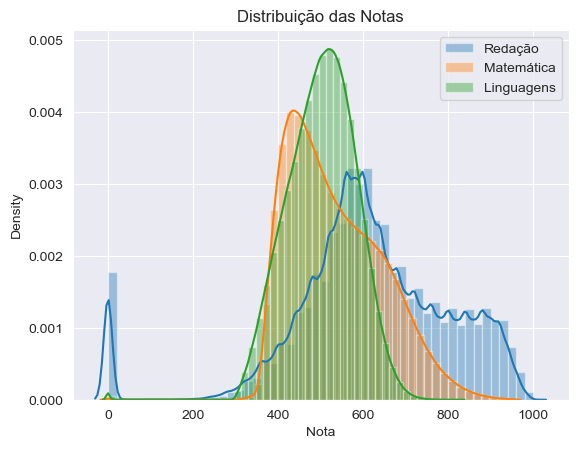

In [30]:
subjects = {'NU_NOTA_REDACAO': 'Redação',
            'NU_NOTA_MT': 'Matemática',
            'NU_NOTA_LC': 'Linguagens'}

fig, ax = plt.subplots()
for col, label in subjects.items():
    sns.distplot(df[col], label=label, ax=ax)
ax.set(title='Distribuição das Notas', xlabel='Nota')
ax.legend()
plt.show()

Analisando pelo recorte de raça

In [7]:
print('Representatividade de raça:')
df[['TP_COR_RACA']].value_counts(normalize = True)

Representatividade de raça:


TP_COR_RACA   
Parda             0.429949
Branca            0.401865
Preta             0.121334
Não Declarado     0.020989
Amarela           0.020205
Indígena          0.005657
Sem Informação    0.000001
dtype: float64

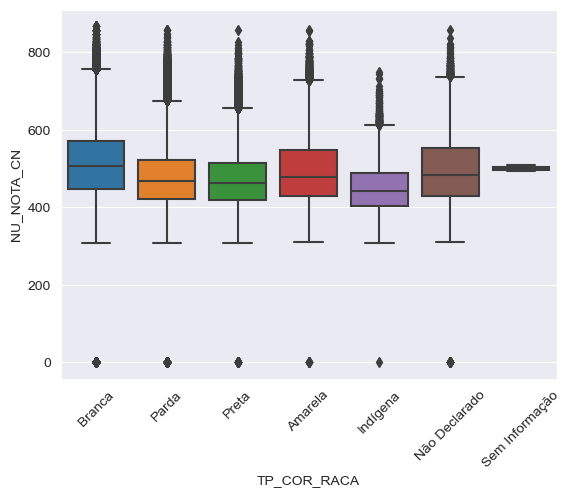

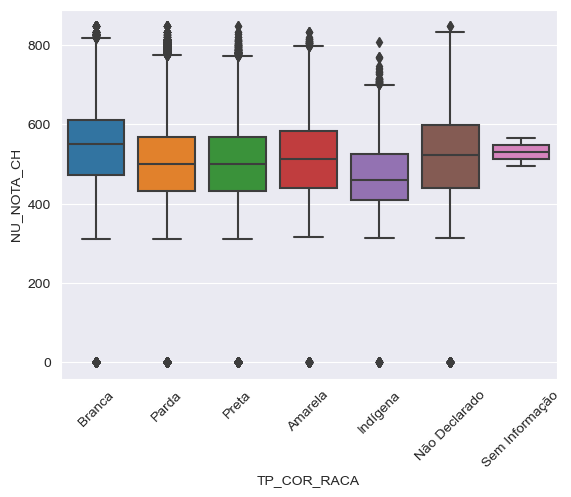

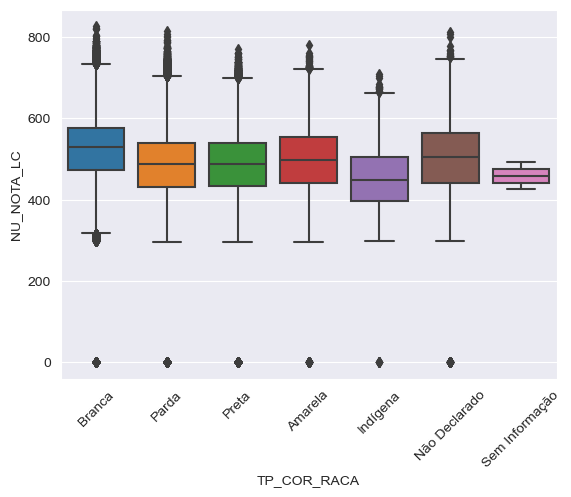

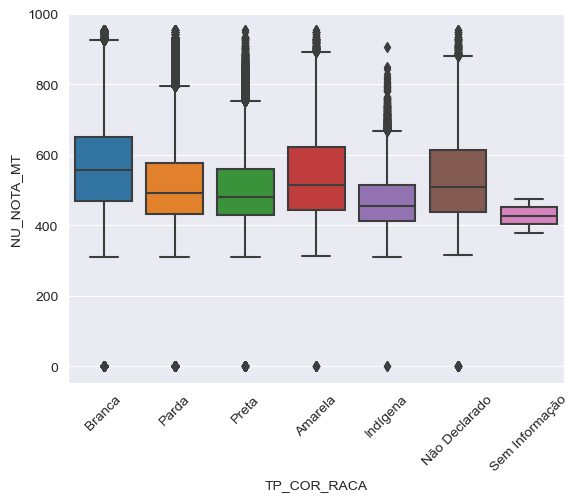

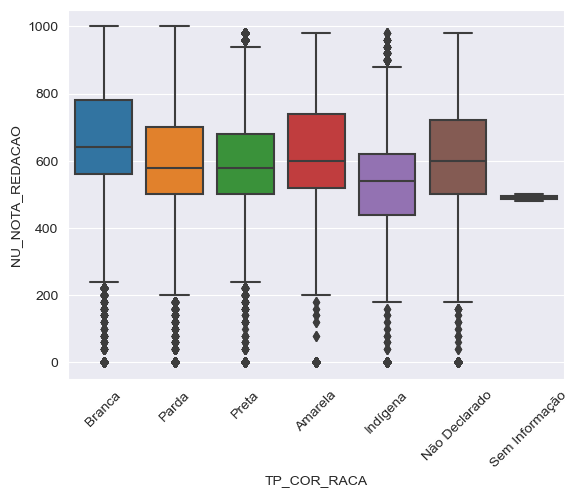

In [12]:
notas = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']

for nota in notas: 
    p = sns.boxplot(data = df, x = 'TP_COR_RACA', y = nota)
    plt.xticks(rotation = 45)
    plt.show()

Analisando pelo recorte de gênero

In [13]:
print('Representatividade de gênero: ')
df[['TP_SEXO']].value_counts(normalize = True)

Representatividade de gênero: 


TP_SEXO
F          0.616705
M          0.383295
dtype: float64

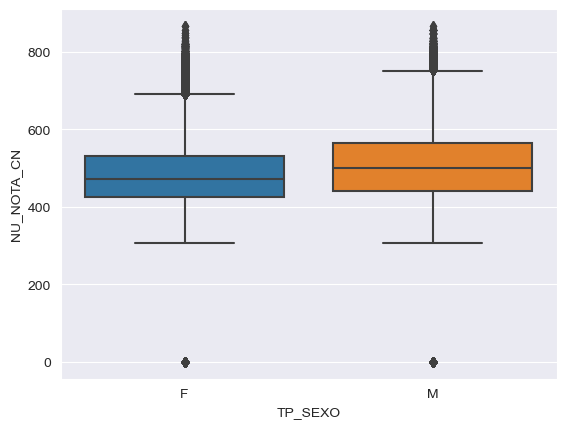

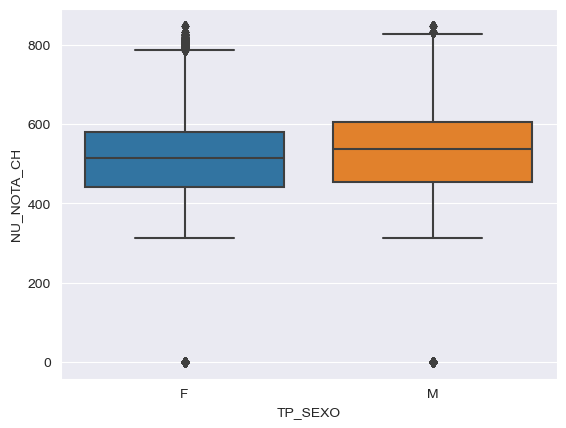

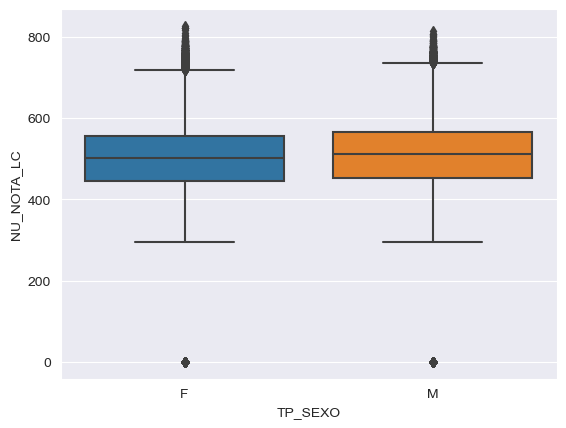

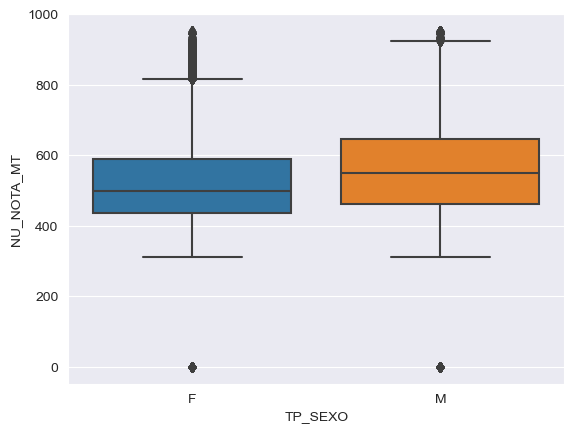

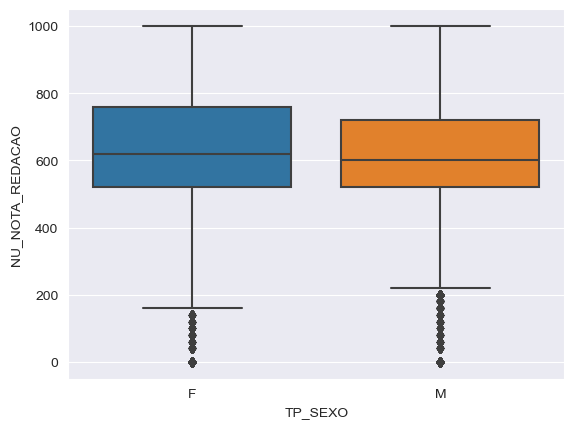

In [14]:
notas = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']

for nota in notas: 
    p = sns.boxplot(data = df, x = 'TP_SEXO', y = nota)
    plt.show()

## Clusterização dos alunos 

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score

ERROR! Session/line number was not unique in database. History logging moved to new session 60


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\pamst\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\pamst\AppData\Local\Temp\ipykernel_96300\720182345.py", line 3, in <module>
    from sklearn.cluster import KMeans
  File "C:\Users\pamst\anaconda3\lib\site-packages\sklearn\cluster\__init__.py", line 6, in <module>
    from ._spectral import spectral_clustering, SpectralClustering
  File "C:\Users\pamst\anaconda3\lib\site-packages\sklearn\cluster\_spectral.py", line 16, in <module>
    from ..neighbors import kneighbors_graph, NearestNeighbors
  File "C:\Users\pamst\anaconda3\lib\site-packages\sklearn\neighbors\__init__.py", line 9, in <module>
    from ._graph import kneighbors_graph, radius_neighbors_graph
  File "C:\Users\pamst\anaconda3\lib\site-packages\sklearn\neighbors\_graph.py", line 7, in <module>
    from ._base import KNeighborsMixin, RadiusNeighborsMixin
  File

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\pamst\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\pamst\AppData\Local\Temp\ipykernel_96300\720182345.py", line 3, in <module>
    from sklearn.cluster import KMeans
  File "C:\Users\pamst\anaconda3\lib\site-packages\sklearn\cluster\__init__.py", line 6, in <module>
    from ._spectral import spectral_clustering, SpectralClustering
  File "C:\Users\pamst\anaconda3\lib\site-packages\sklearn\cluster\_spectral.py", line 16, in <module>
    from ..neighbors import kneighbors_graph, NearestNeighbors
  File "C:\Users\pamst\anaconda3\lib\site-packages\sklearn\neighbors\__init__.py", line 9, in <module>
    from ._graph import kneighbors_graph, radius_neighbors_graph
  File "C:\Users\pamst\anaconda3\lib\site-packages\sklearn\neighbors\_graph.py", line 7, in <module>
    from ._base import KNeighborsMixin, RadiusNeighborsMixin
  File

In [ ]:
cols = ['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL',
       'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU',
       'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', 
       'CO_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC',
       'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC', 'CO_MUNICIPIO_PROVA',
       'CO_UF_PROVA', 'PIB_2019']

df_c = df[cols].copy()
df_c['TP_SEXO'] = df_c['TP_SEXO'].replace({'F':1,'M':0}).astype(int)
df_c['TP_COR_RACA'] = df_c['TP_COR_RACA'].replace({"Não Declarado":0, 
                 "Branca":1, 
                 "Preta":2, 
                 "Parda":3, 
                 "Amarela":4, 
                 "Indígena":5, 
                 "Sem Informação":6}).astype(int)

df_c = df_c.fillna(-1)

ERROR! Session/line number was not unique in database. History logging moved to new session 61


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\pamst\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\pamst\AppData\Local\Temp\ipykernel_96300\779046827.py", line 8, in <module>
    df_c = df[cols].copy()
  File "C:\Users\pamst\anaconda3\lib\site-packages\pandas\core\frame.py", line 3517, in __getitem__
    data = self._take_with_is_copy(indexer, axis=1)
  File "C:\Users\pamst\anaconda3\lib\site-packages\pandas\core\generic.py", line 3716, in _take_with_is_copy
    result = self.take(indices=indices, axis=axis)
  File "C:\Users\pamst\anaconda3\lib\site-packages\pandas\core\generic.py", line 3703, in take
    new_data = self._mgr.take(
  File "C:\Users\pamst\anaconda3\lib\site-packages\pandas\core\internals\managers.py", line 897, in take
    return self.reindex_indexer(
  File "C:\Users\pamst\anaconda3\lib\site-packages\pandas\core\internals\managers.py", line 682, in reinde

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\pamst\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\pamst\AppData\Local\Temp\ipykernel_96300\779046827.py", line 8, in <module>
    df_c = df[cols].copy()
  File "C:\Users\pamst\anaconda3\lib\site-packages\pandas\core\frame.py", line 3517, in __getitem__
    data = self._take_with_is_copy(indexer, axis=1)
  File "C:\Users\pamst\anaconda3\lib\site-packages\pandas\core\generic.py", line 3716, in _take_with_is_copy
    result = self.take(indices=indices, axis=axis)
  File "C:\Users\pamst\anaconda3\lib\site-packages\pandas\core\generic.py", line 3703, in take
    new_data = self._mgr.take(
  File "C:\Users\pamst\anaconda3\lib\site-packages\pandas\core\internals\managers.py", line 897, in take
    return self.reindex_indexer(
  File "C:\Users\pamst\anaconda3\lib\site-packages\pandas\core\internals\managers.py", line 682, in reinde

In [67]:
for n in range(2, 6):  # Try different numbers of clusters from 2 to 5
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(df_c)
    labels = kmeans.labels_
    score = silhouette_score(df_c, labels)
    if score > best_score:
        best_score = score
        best_n_clusters = n

# Fit the K-Means model with the best number of clusters
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
kmeans.fit(df_c)
predicted_labels = kmeans.labels_

# Get the cluster centers
centroids = kmeans.cluster_centers_

# Plot the clustered data with K-Means labels
plt.subplot(1, 2, 2)
plt.scatter(data[:, 0], data[:, 1], c=predicted_labels, cmap='viridis', marker='o', edgecolor='k')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.title("K-Means Clusters")

plt.show()

print(f"Optimal number of clusters: {best_n_clusters}")

ERROR! Session/line number was not unique in database. History logging moved to new session 50


KeyboardInterrupt: 

## Pré processamento dos dados

In [9]:
def variaveis(df_, prova):
    """
    Função que cria variável dependente e variáveis independentes para o modelo, por prova. 
    """
    
    ##Selecionar um df apenas com as variáveis do modelo 

    var_list = ['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL',
           'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU',
           'TP_ESCOLA', 'IN_TREINEIRO', 
           'NO_MUNICIPIO_PROVA', 'SG_UF_PROVA', 'PIB_2019', prova]

    df_ = df_[var_list]

    ##Drop linhas em que não há nota ou que a nota == 0    
    df_ = df_.query(f'({prova} != 0) & ({prova} == {prova})').reset_index(drop = True)

    ##Separação da variável dependente e independentes 

    y = df_[prova]
    x = df_.drop(prova, axis = 1)
    return y, x

###Vars treino 
y_mt, x_mt = variaveis('NU_NOTA_MT') #modelo matemática
y_r, x_r = variaveis('NU_NOTA_REDACAO') #modelo redação 
y_l, x_l = variaveis('NU_NOTA_LC') #modelo linguagens 
y_ch, x_ch = variaveis('NU_NOTA_CH') #modelo ciências humanas 
y_cn, x_cn = variaveis('NU_NOTA_CN') #modelo ciências naturais 

### Modelo LightGBM - Prova de Matemática

In [12]:
#Model tuning com optuna 

def tune_prova(x, y):
    """
    Funcao faz calibragem do modelo 
        - Args: x (vars independentes), y (var dependente)
        - Return: dict com melhores parametros 
    """
    
    ###Transformar as colunas categóricas em category
    for col in ['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL',
       'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'IN_TREINEIRO',
       'NO_MUNICIPIO_PROVA', 'SG_UF_PROVA',]:
        x[col] = x[col].astype('category')
    
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.25)
    
    def objective(trial):
        """
        Cria o Trial da funcao 
        
        """
    
        params = {
            'objective': 'regression',
            'metric': 'mae', #usando MAE como métrica 
            'boosting_type': 'gbdt',
            
            ###Parametros
            'num_leaves': trial.suggest_int('num_leaves', 2, 256),
            'max_depth': trial.suggest_int('max_depth', 2, 20),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
    #         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
    #         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
    #         'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
    #         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
            
            'seed': 42, 
            'n_jobs': -1, ##use all GPUs 
        }

        # Train and evaluate model
        model = lgb.train(params, lgb.Dataset(train_x, label=train_y), num_boost_round=1000,
                          valid_sets=[lgb.Dataset(test_x, label=test_y)], early_stopping_rounds=50,
                          verbose_eval=False)

        y_pred = model.predict(test_x)
        mae = mean_absolute_error(test_y, y_pred)
        return mae

    # Create Optuna study and run optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=25)

    # Print best parameters and MAE
    print('Best parameters:', study.best_params)
    print('Best MAE:', study.best_value)
    return study.best_params #retorna um dict com os melhores parâmetros encontrados. 

In [14]:
# params_mt = tune_prova(x_mt, y_mt)
# locals().update(params_mt)

In [15]:
params_mt = {'num_leaves': 78, 'max_depth': 14, 'min_child_samples': 59, 'learning_rate': 0.017100295222251444, 'lambda_l1': 0.00018465974023419064, 'lambda_l2': 2.5527375993322497e-08}

locals().update(params_mt)

Criando validação cruzada: 

In [32]:
def train_test(x, y, params, n_splits=None):
    """
    Função divide o dataframe entre treino e teste usando k-fold cross-validation e retorna o dataframe de teste 
    (com coluna de real e previsto) além do modelo lgbm, para analisar o feature importance.
        - Args: 
            x (vars independentes), 
            y (var dependente), 
            params (dict de parametros)
            n_splits (numero de validacoes)
        - Return:
            - Dataframe de teste 
            - Modelos testados
        
    """
    
    #Transformar as colunas categóricas em category
    for col in ['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL',
                'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'IN_TREINEIRO',
                'NO_MUNICIPIO_PROVA', 'SG_UF_PROVA']:
        x[col] = x[col].astype('category')
    
    kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)
    
    # Listas para guardar os resultados 
    predictions = []
    models = []
    
    for train_index, test_index in kf.split(x):
        train_x, test_x = x.iloc[train_index], x.iloc[test_index]
        train_y, test_y = y.iloc[train_index], y.iloc[test_index]
        
        # Train the model and make predictions
        lgb_model = lgb.LGBMRegressor(**params, objective='regression', random_state=42)
        lgb_model.fit(train_x, train_y)
        pred = lgb_model.predict(test_x)
        
        # Store predictions and models
        predictions.append(pred)
        models.append(lgb_model)
    
    # Concatenate predictions from all folds
    pred_concat = np.concatenate(predictions)
    test_y_concat = np.concatenate([y.iloc[test_index] for _, test_index in kf.split(x)])
    
    df_test = pd.DataFrame({'actual': test_y_concat, 'prediction': pred_concat})
    df_test = pd.concat([df_test.reset_index(drop=True), x.reset_index(drop=True)], axis=1)
    
    #Calc dos erros:
    mae = mean_absolute_error(df_test['actual'], df_test['prediction'])
    r2  = r2_score(df_test['actual'], df_test['prediction'])
    
    return print(f'Dataset Teste: \n MAE: {mae} \n R2: {r2}')

In [33]:
#Dataframe com resultados e modelo 
df_test, mt_lgb_model = train_test(x_mt, y_mt, params_mt, n_splits = 5)

[LightGBM] [Warning] lambda_l1 is set=0.00018465974023419064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018465974023419064
[LightGBM] [Warning] lambda_l2 is set=2.5527375993322497e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5527375993322497e-08
[LightGBM] [Warning] lambda_l1 is set=0.00018465974023419064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018465974023419064
[LightGBM] [Warning] lambda_l2 is set=2.5527375993322497e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5527375993322497e-08
[LightGBM] [Warning] lambda_l1 is set=0.00018465974023419064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018465974023419064
[LightGBM] [Warning] lambda_l2 is set=2.5527375993322497e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5527375993322497e-08
[LightGBM] [Warning] lambda_l1 is set=0.00018465974023419064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018465974023419064
[LightGBM]

TypeError: cannot unpack non-iterable NoneType object

In [23]:
##Modelo 
model_mt = lgb.LGBMRegressor(**params_mt,objective='regression', random_state=42)
model_mt = model_mt.fit(x_mt, y_mt)

[LightGBM] [Warning] lambda_l1 is set=0.00018465974023419064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018465974023419064
[LightGBM] [Warning] lambda_l2 is set=2.5527375993322497e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5527375993322497e-08


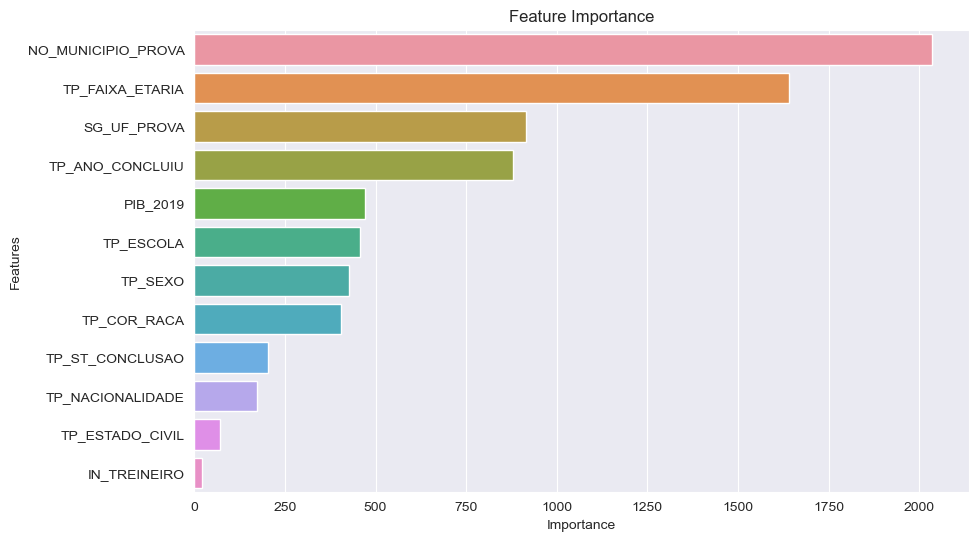

In [24]:
#Construir o feature importance
feat_imp = pd.DataFrame({'Feature': x_mt.columns, 'importance': model_mt.feature_importances_})
feat_imp = feat_imp.sort_values(by = 'importance', ascending = False)

#plot
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='Feature', data=feat_imp, orient='h')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

### Modelo LighGBM - Redação 

In [37]:
# #Tune do modelo 
# params_r = tune_prova(x_r, y_r)
# locals().update(params_r)

In [38]:
params_r = {'num_leaves': 38, 'max_depth': 14, 'min_child_samples': 86, 'learning_rate': 0.016002592176639057, 'lambda_l1': 0.27889534386349013, 'lambda_l2': 0.00038479382704436016}
locals().update(params_r)